🔹 CSV 로드
train rows: 1570, test rows: 3140
train id col: ID, label col: target, test id col: ID
🔹 Train 스캔 중...
[train] processed: 1000
[train] total: 1570 | scanned: 1570 | missing: 0
🔹 Test  스캔 중...
[test] processed: 1000
[test] processed: 2000
[test] processed: 3000
[test] total: 3140 | scanned: 3140 | missing: 0
✅ metrics saved: /root/cv_project/data/outputs/image_quality_metrics.csv
🔹 분포 비교 플롯 생성...


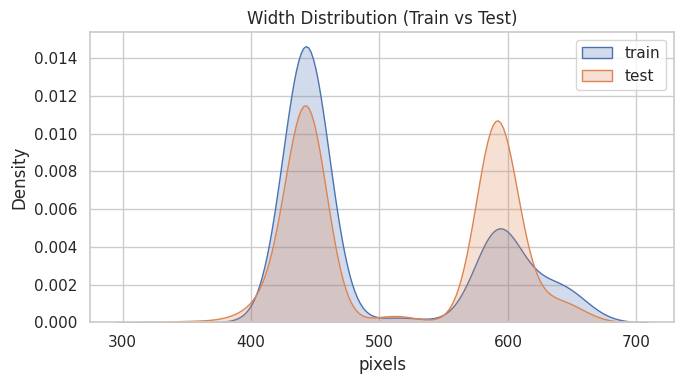

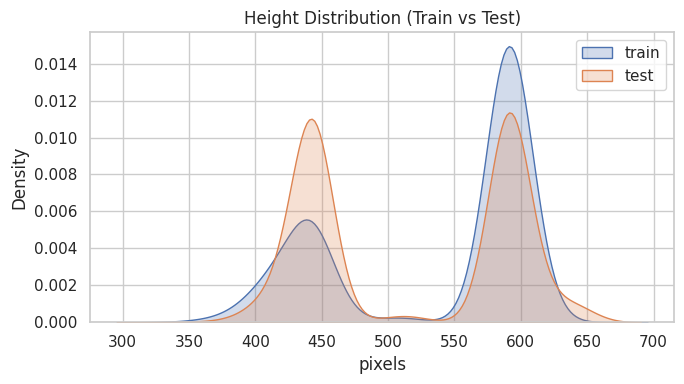

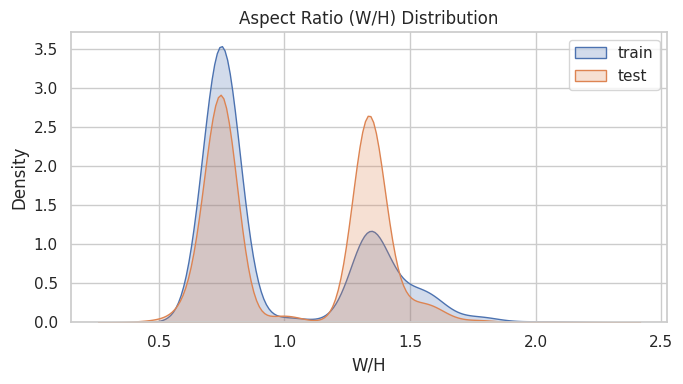

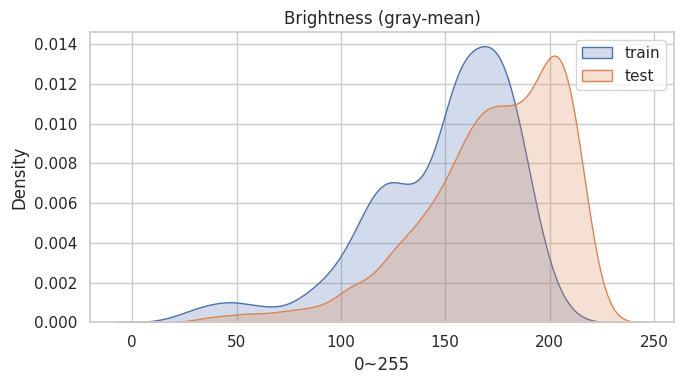

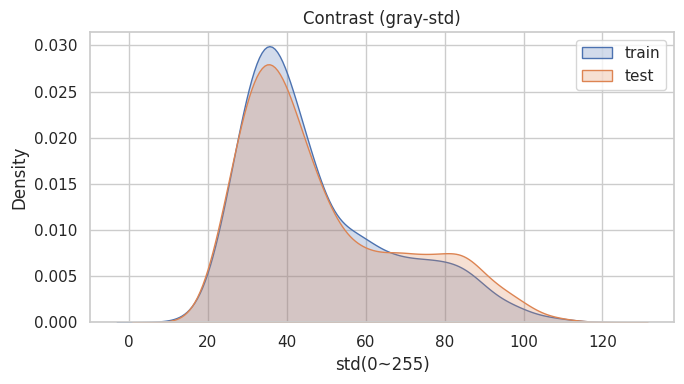

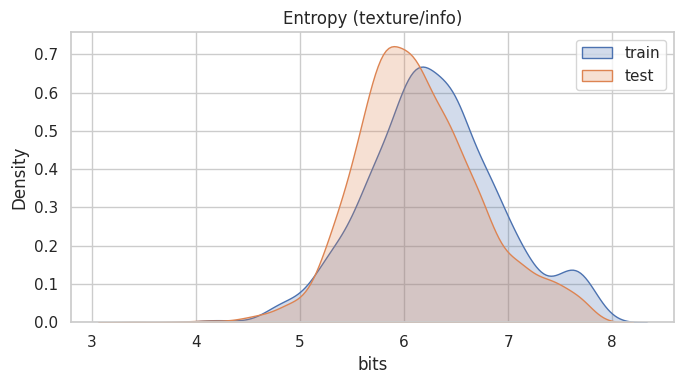

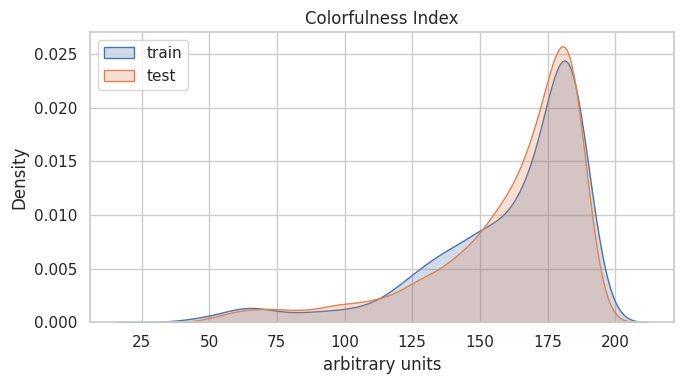

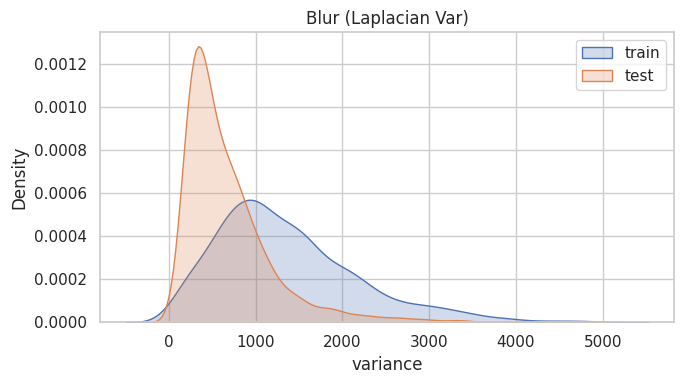

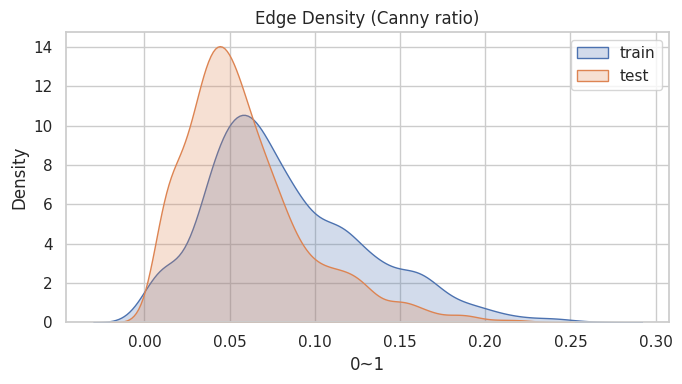

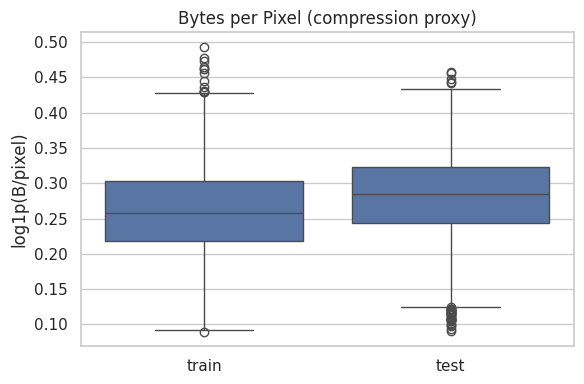

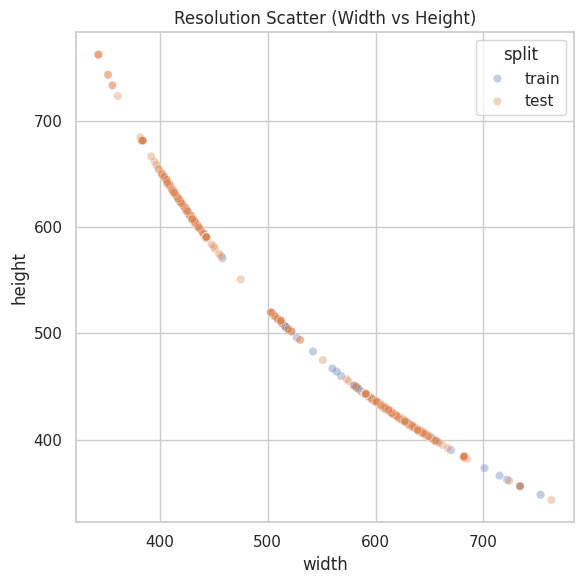

✅ summary saved: /root/cv_project/data/outputs/summary_stats.csv
✅ outlier report saved: /root/cv_project/data/outputs/outlier_report.csv
✅ flag summary saved: /root/cv_project/data/outputs/flag_summary.csv

===== 🔎 Quick Snapshot =====
Train issues:
   split       issue  count  total     ratio
0  train   any_issue    100   1570  0.063694
1  train   low_edges     96   1570  0.061146
2  train    too_dark      4   1570  0.002548
3  train   small_res      0   1570  0.000000
4  train  too_bright      0   1570  0.000000
5  train  too_blurry      0   1570  0.000000

Test issues:
  split       issue  count  total     ratio
0  test   low_edges    343   3140  0.109236
1  test   any_issue    343   3140  0.109236
2  test   small_res      0   3140  0.000000
3  test    too_dark      0   3140  0.000000
4  test  too_bright      0   3140  0.000000
5  test  too_blurry      0   3140  0.000000

✨ Done.  OUT_DIR = /root/cv_project/data/outputs


In [1]:
# =========================================================
# 📊 Train vs Test Image Quality EDA (Document Images)
# =========================================================
# 기능:
#  - train/test 이미지 로드 및 견고한 경로 해결(확장자 혼합 대응)
#  - 해상도/종횡비/밝기(그레이스케일 평균)/대비(std)/엔트로피
#  - 블러(라플라시안 분산)/엣지 밀도(캐니 에지 비율)/색감(Colorfulness)
#  - 픽셀당 용량(byte-per-pixel: 압축 강도 간접 추정)
#  - 분포 비교 플롯, 이상치(너무 어둡/밝/작/블러) 레포트, CSV 저장
# =========================================================

import os
import io
import gc
import math
import glob
import json
import numpy as np
import pandas as pd
from PIL import Image, ImageStat, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns

# 선택: OpenCV가 있다면 Blur/Edge를 더 정확히 계산
try:
    import cv2
    OPENCV_OK = True
except Exception:
    OPENCV_OK = False

# -----------------------------
# 0) 경로/환경 설정
# -----------------------------
BASE_DIR   = '/root/cv_project/data'
TRAIN_CSV  = os.path.join(BASE_DIR, 'train.csv')               # (id, label 등)
SAMPLE_CSV = os.path.join(BASE_DIR, 'sample_submission.csv')   # (id 등)
TRAIN_DIR  = os.path.join(BASE_DIR, 'train')
TEST_DIR   = os.path.join(BASE_DIR, 'test')
OUT_DIR    = os.path.join(BASE_DIR, 'outputs')                 # 결과 저장 폴더
os.makedirs(OUT_DIR, exist_ok=True)

# 전체 스캔이 너무 크면 샘플링 크기 조정
MAX_TRAIN_SAMPLES = None   # 예: 4000 로 제한 가능
MAX_TEST_SAMPLES  = None   # 예: 4000 로 제한 가능

# -----------------------------
# 1) 유틸: 컬럼 탐색/경로 해결
# -----------------------------
def find_column(df, keywords):
    keys = [k.lower() for k in keywords]
    for col in df.columns:
        c = col.lower()
        if any(k in c for k in keys):
            return col
    return None

COMMON_EXTS = ('.jpg','.jpeg','.png','.bmp','.tif','.tiff','.JPG','.JPEG','.PNG','.BMP','.TIF','.TIFF')

def resolve_image_path(img_dir: str, name: str):
    """
    이름이 'abc' 또는 'abc.jpg'든 견고히 경로를 찾아줌.
    """
    name = str(name)
    base = os.path.splitext(os.path.basename(name))[0]
    # 1) 원문 그대로 시도
    p1 = os.path.join(img_dir, name)
    if os.path.exists(p1):
        return p1
    # 2) 후보 확장자 전수 검사
    for ext in COMMON_EXTS:
        cand = os.path.join(img_dir, base + ext)
        if os.path.exists(cand):
            return cand
    return None

def image_file_size(path: str) -> int:
    try:
        return os.path.getsize(path)
    except Exception:
        return -1

# -----------------------------
# 2) 품질 지표 계산 함수
# -----------------------------
def calc_entropy(pil_img_gray: Image.Image) -> float:
    # Pillow 10+: ImageStat entropy 제거됨 → 히스토그램 기반
    hist = pil_img_gray.histogram()
    hist = np.array(hist, dtype=np.float64)
    p = hist / hist.sum() if hist.sum() else hist
    p = p[p > 0]
    return float(-(p * np.log2(p)).sum()) if p.size else 0.0

def calc_colorfulness(np_rgb: np.ndarray) -> float:
    # Hasler & Süsstrunk (2003) 색감지수 근사
    # 입력: H x W x 3, RGB [0,255]
    if np_rgb.ndim != 3 or np_rgb.shape[2] != 3:
        return 0.0
    R, G, B = np_rgb[:,:,0], np_rgb[:,:,1], np_rgb[:,:,2]
    rg = np.abs(R - G)
    yb = np.abs(0.5*(R + G) - B)
    rg_mean, rg_std = rg.mean(), rg.std()
    yb_mean, yb_std = yb.mean(), yb.std()
    return math.sqrt(rg_std**2 + yb_std**2) + 0.3*math.sqrt(rg_mean**2 + yb_mean**2)

def calc_blur_and_edges(np_gray: np.ndarray):
    """
    반환: (lap_var, edge_density)
    - lap_var: 라플라시안 분산(값이 작을수록 블러)
    - edge_density: 캐니에지 픽셀 비율(0~1)
    """
    if not OPENCV_OK:
        # OpenCV가 없으면 간이 라플라시안 근사(NumPy)
        # 이 값은 비교용으로만 사용 (절대값 해석 X)
        kernel = np.array([[0, 1, 0],
                           [1,-4, 1],
                           [0, 1, 0]], dtype=np.float32)
        from scipy.signal import convolve2d  # 만약 SciPy가 없다면 try/except 하거나 0 반환
        try:
            lap = convolve2d(np_gray.astype(np.float32), kernel, mode='same', boundary='symm')
            lap_var = float(lap.var())
            edge_density = np.nan
            return lap_var, edge_density
        except Exception:
            return np.nan, np.nan
    # OpenCV 경로
    lap_var = float(cv2.Laplacian(np_gray, cv2.CV_64F).var())
    edges = cv2.Canny(np_gray, 100, 200)
    edge_density = float((edges > 0).mean()) if edges.size else np.nan
    return lap_var, edge_density

def compute_image_metrics(path: str):
    """
    path에서 이미지 열어 다양한 품질지표 계산.
    실패 시 None 반환.
    """
    try:
        with Image.open(path) as im:
            im = im.convert('RGB')       # 문서 이미지라도 RGB로 통일
            w, h = im.size
            aspect = w / h if h > 0 else np.nan
            size_bytes = image_file_size(path)
            bpp = (size_bytes / (w*h)) if (w>0 and h>0 and size_bytes>0) else np.nan  # byte per pixel

            # 밝기/대비: 그레이스케일 평균/표준편차
            gray = ImageOps.grayscale(im)
            gray_np = np.array(gray, dtype=np.uint8)
            mean_gray = float(gray_np.mean())
            std_gray  = float(gray_np.std())

            # 엔트로피: 질감/정보량 근사
            entropy = calc_entropy(gray)

            # 색감: RGB 기반
            rgb_np = np.array(im, dtype=np.uint8)
            colorfulness = float(calc_colorfulness(rgb_np))

            # 블러/엣지 밀도
            lap_var, edge_density = calc_blur_and_edges(gray_np)

            return {
                'width': w, 'height': h, 'aspect_ratio': aspect,
                'file_size': size_bytes, 'bytes_per_pixel': bpp,
                'mean_gray': mean_gray, 'std_gray': std_gray,
                'entropy': entropy, 'colorfulness': colorfulness,
                'lap_var': lap_var, 'edge_density': edge_density,
            }
    except Exception:
        return None

# -----------------------------
# 3) 데이터 로드 & ID 컬럼 선택
# -----------------------------
print("🔹 CSV 로드")
train_df = pd.read_csv(TRAIN_CSV)
sample_df = pd.read_csv(SAMPLE_CSV)

train_id_col = find_column(train_df, ['id','file','image','path'])
test_id_col  = find_column(sample_df, ['id','file','image','path'])
label_col    = find_column(train_df, ['label','target','class'])

if train_id_col is None:
    raise ValueError(f"train.csv에서 id 컬럼을 찾을 수 없습니다. ({list(train_df.columns)})")
if test_id_col is None:
    raise ValueError(f"sample_submission.csv에서 id 컬럼을 찾을 수 없습니다. ({list(sample_df.columns)})")

# 샘플링(선택)
if MAX_TRAIN_SAMPLES:
    train_df = train_df.sample(n=MAX_TRAIN_SAMPLES, random_state=42).reset_index(drop=True)
if MAX_TEST_SAMPLES:
    sample_df = sample_df.sample(n=MAX_TEST_SAMPLES, random_state=42).reset_index(drop=True)

print(f"train rows: {len(train_df)}, test rows: {len(sample_df)}")
print(f"train id col: {train_id_col}, label col: {label_col}, test id col: {test_id_col}")

# -----------------------------
# 4) 스캔 루프
# -----------------------------
def scan_split(df: pd.DataFrame, id_col: str, img_dir: str, split: str):
    rows = []
    missing = 0
    for i, name in enumerate(df[id_col].tolist()):
        p = resolve_image_path(img_dir, name)
        if p is None:
            missing += 1
            continue
        m = compute_image_metrics(p)
        if m is None:
            continue
        m.update({
            'split': split,
            'id': str(name),
            'path': p
        })
        if label_col in df.columns:
            m['label'] = df.loc[i, label_col]
        rows.append(m)
        if (i+1) % 1000 == 0:
            print(f"[{split}] processed: {i+1}")
    print(f"[{split}] total: {len(df)} | scanned: {len(rows)} | missing: {missing}")
    return pd.DataFrame(rows)

print("🔹 Train 스캔 중...")
train_metrics = scan_split(train_df, train_id_col, TRAIN_DIR, 'train')
print("🔹 Test  스캔 중...")
test_metrics  = scan_split(sample_df, test_id_col, TEST_DIR, 'test')

all_metrics = pd.concat([train_metrics, test_metrics], ignore_index=True)
all_metrics.to_csv(os.path.join(OUT_DIR, 'image_quality_metrics.csv'), index=False)
print(f"✅ metrics saved: {os.path.join(OUT_DIR, 'image_quality_metrics.csv')}")

# -----------------------------
# 5) 분포 비교 플롯
# -----------------------------
sns.set(style='whitegrid')

def kde_plot(col, title, xlabel, clip=None):
    plt.figure(figsize=(7,4))
    for sp, color in [('train', None), ('test', None)]:
        s = all_metrics.loc[all_metrics['split']==sp, col].dropna()
        if clip:
            s = s.clip(*clip)
        sns.kdeplot(s, fill=True, label=sp)
    plt.title(title); plt.xlabel(xlabel); plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'kde_{col}.png'), dpi=140)
    plt.show()

def box_plot(col, title, ylabel, log=False, clip=None):
    plt.figure(figsize=(6,4))
    data = all_metrics[['split', col]].dropna()
    if clip:
        data[col] = data[col].clip(*clip)
    if log:
        data[col] = np.log1p(data[col])
        ylabel = f'log1p({ylabel})'
    sns.boxplot(x='split', y=col, data=data)
    plt.title(title); plt.ylabel(ylabel); plt.xlabel('')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'box_{col}.png'), dpi=140)
    plt.show()

print("🔹 분포 비교 플롯 생성...")
# 해상도/비율
kde_plot('width',  'Width Distribution (Train vs Test)',  'pixels', clip=(0, np.quantile(all_metrics['width'].dropna(), 0.99)))
kde_plot('height', 'Height Distribution (Train vs Test)', 'pixels', clip=(0, np.quantile(all_metrics['height'].dropna(),0.99)))
kde_plot('aspect_ratio', 'Aspect Ratio (W/H) Distribution', 'W/H', clip=(0, 5))

# 밝기/대비/엔트로피
kde_plot('mean_gray', 'Brightness (gray-mean)', '0~255', clip=(0,255))
kde_plot('std_gray',  'Contrast (gray-std)', 'std(0~255)', clip=(0,128))
kde_plot('entropy',   'Entropy (texture/info)', 'bits', clip=(0,8))

# 색감/블러/엣지/용량
kde_plot('colorfulness','Colorfulness Index','arbitrary units')
kde_plot('lap_var',     'Blur (Laplacian Var)', 'variance')
kde_plot('edge_density','Edge Density (Canny ratio)','0~1', clip=(0,1))
box_plot('bytes_per_pixel','Bytes per Pixel (compression proxy)','B/pixel', log=True)

# 해상도 산점도
plt.figure(figsize=(6,6))
sns.scatterplot(data=all_metrics, x='width', y='height', hue='split', alpha=0.35)
plt.title('Resolution Scatter (Width vs Height)')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'scatter_resolution.png'), dpi=140)
plt.show()

# -----------------------------
# 6) 집계 테이블 & 이상치 규칙
# -----------------------------
def summarize(df, name):
    cols = ['width','height','aspect_ratio','mean_gray','std_gray',
            'entropy','colorfulness','lap_var','edge_density','bytes_per_pixel']
    agg = df[cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
    agg.insert(0, 'metric', agg.index)
    agg.insert(1, 'split', name)
    return agg.reset_index(drop=True)

sum_train = summarize(all_metrics[all_metrics['split']=='train'], 'train')
sum_test  = summarize(all_metrics[all_metrics['split']=='test'],  'test')
summary   = pd.concat([sum_train, sum_test], ignore_index=True)
summary.to_csv(os.path.join(OUT_DIR, 'summary_stats.csv'), index=False)
print(f"✅ summary saved: {os.path.join(OUT_DIR, 'summary_stats.csv')}")

# 간단한 이상치 규칙(임계는 상황 맞게 조정)
#  - 너무 작은 해상도: min(width,height) < 256
#  - 너무 어둡/밝: mean_gray < 25 또는 > 230
#  - 너무 흐림: lap_var < 20 (경험값; 데이터에 따라 조정)
#  - 엣지 부족: edge_density < 0.02 (문서 경계/텍스트가 거의 없음)
def flag_outliers(df):
    cond_small = (df[['width','height']].min(axis=1) < 256)
    cond_dark  = (df['mean_gray'] < 25)
    cond_bright= (df['mean_gray'] > 230)
    cond_blur  = (df['lap_var'] < 20) if 'lap_var' in df.columns else False
    cond_edge  = (df['edge_density'] < 0.02) if 'edge_density' in df.columns else False
    flags = pd.DataFrame({
        'small_res': cond_small,
        'too_dark': cond_dark,
        'too_bright': cond_bright,
        'too_blurry': cond_blur,
        'low_edges': cond_edge
    })
    flags['any_issue'] = flags.any(axis=1)
    return flags

flags = flag_outliers(all_metrics)
report = pd.concat([all_metrics[['split','id','path','width','height','mean_gray','lap_var','edge_density','bytes_per_pixel']], flags], axis=1)
report.to_csv(os.path.join(OUT_DIR, 'outlier_report.csv'), index=False)
print(f"✅ outlier report saved: {os.path.join(OUT_DIR, 'outlier_report.csv')}")

# split별 이상치 요약
def summarize_flags(rep, split):
    sub = rep[rep['split']==split]
    total = len(sub)
    if total == 0:
        return pd.DataFrame()
    rates = sub[['small_res','too_dark','too_bright','too_blurry','low_edges','any_issue']].mean().sort_values(ascending=False)
    df = rates.to_frame(name='ratio').reset_index().rename(columns={'index':'issue'})
    df['count'] = (df['ratio'] * total).astype(int)
    df['total'] = total
    df['split'] = split
    return df[['split','issue','count','total','ratio']]

train_flag_summary = summarize_flags(report, 'train')
test_flag_summary  = summarize_flags(report, 'test')
flag_summary = pd.concat([train_flag_summary, test_flag_summary], ignore_index=True)
flag_summary.to_csv(os.path.join(OUT_DIR, 'flag_summary.csv'), index=False)
print(f"✅ flag summary saved: {os.path.join(OUT_DIR, 'flag_summary.csv')}")

print("\n===== 🔎 Quick Snapshot =====")
print("Train issues:")
print(train_flag_summary)
print("\nTest issues:")
print(test_flag_summary)

print("\n✨ Done.  OUT_DIR =", OUT_DIR)
